Jupyter script to plot the figures presented in 

A dynamically-structured renewal process-based matrix population model for life histories observed under variable conditions.
Kamil Erguler, Jacob Mendel, Dusan Veljko Petric, Mina Petric, Mihaela Kavran, Murat Can Demirok, Filiz Gunay, Pantelis Georgiades, Bulent Alten, Jos Lelieveld.

 Copyright (C) 2022  Kamil Erguler
 
     This program is free software: you can redistribute it and/or modify
     it under the terms of the GNU General Public License as published by
     the Free Software Foundation, either version 3 of the License, or
     any later version.
 
     This program is distributed in the hope that it will be useful,
     but WITHOUT ANY WARRANTY; without even the implied warranty of
     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
     GNU General Public License for more details (<https://www.gnu.org/licenses/>).

In [1]:
import numpy
import matplotlib.pyplot as plt

from scipy.stats import gamma
from scipy.stats import nbinom
from scipy.stats import poisson
from scipy.stats import erlang
from scipy.stats import norm as gaussian

from numpy.random import uniform
from numpy.random import normal
from numpy.random import poisson as rpois
from numpy.random import binomial, choice
from numpy.random import geometric

from scipy.interpolate import interp1d
from scipy.special import gamma as fgamma
from scipy.special import gammaincc
from scipy.special import gammainccinv
from scipy.special import factorial

from scipy.integrate import odeint

# This is the Python wrapper for the sPop2 library available from https://github.com/kerguler/sPop2
from spop2 import spop
from spop2 import approximate

import pandas
import run_noise

import model
import modelsim
import culex
import vtemp

prange = [5,50,95]

Setting up RNG GSL_RNG for Python


Env. data check: True
Quantized: True


# Figure 1

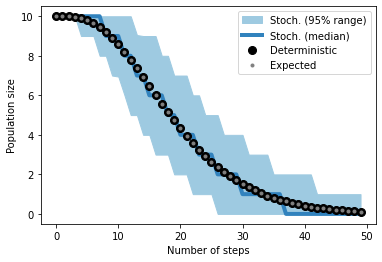

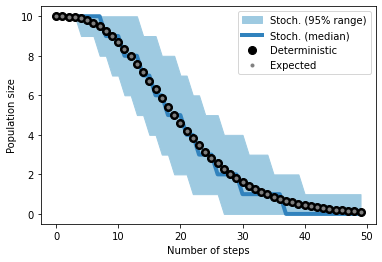

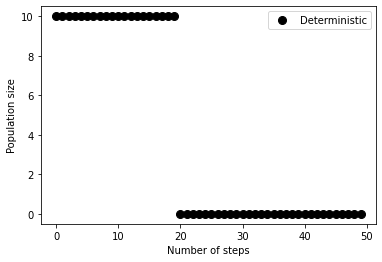

In [6]:
N = 10.0
mu = 20.0
sd = 10.0

def simDet(mode):
    a = spop(stochastic=False,gamma_fun=mode)
    a.add(0,0,0,0,N)
    retd = [[0]+a.read()]
    for n in numpy.arange(1,50):
        a.iterate(0,mu,sd,0,0,0)
        retd.append([n]+a.read())
    return numpy.array(retd)

def simStoch(mode):
    rets = []
    for r in range(1000):
        a = spop(stochastic=True,gamma_fun=mode)
        a.add(0,0,0,0,N)
        tmp = [[0]+a.read()]
        for n in numpy.arange(1,50):
            a.iterate(0,mu,sd,0,0,0)
            tmp.append([n]+a.read())
        rets.append(tmp)
    rets = numpy.array(rets)
    return numpy.percentile(rets,prange,axis=0)

modes = {
    'erlang':{'mode':'MODE_ACCP_ERLANG','figure':'1a'},
    'pascal':{'mode':'MODE_ACCP_PASCAL','figure':'1b'},
    'fixed':{'mode':'MODE_ACCP_FIXED','figure':'1c'}
}

for key in modes:
    if key=='pascal':
        theta = mu / (sd * sd)
        k = mu * theta / (1.0 - theta)
    elif key=='erlang':
        theta = sd * sd / mu
        k = mu / theta
    elif key=='fixed':
        theta = 1
        k = mu
    #
    retd = simDet(modes[key]['mode'])
    if not (key=='fixed'):
        retp = simStoch(modes[key]['mode'])
    #
    xr = numpy.arange(0,50,1)
    handles = []
    if not (key=='fixed'):
        handles.append(plt.fill_between(retp[1][:,0],retp[0][:,1],retp[2][:,1],color="#9ecae1",label="Stoch. (95% range)"))
        handles.append(plt.plot(retp[1][:,0],retp[1][:,1],c="#3182bd",label="Stoch. (median)",lw=4)[0])
    handles.append(plt.plot(retd[:,0],retd[:,1],'o',c="black",label="Deterministic",markersize=8)[0])
    if key=='pascal':
        handles.append(plt.plot(xr,N*(1.0-nbinom.cdf(xr-1,k,theta)),'.',c="gray",label="Expected",markersize=6)[0])
    elif key=='erlang':
        handles.append(plt.plot(xr,N*(1.0-erlang.cdf(xr,k,0,theta)),'.',c="gray",label="Expected",markersize=6)[0])
    plt.legend(handles,[handle.get_label() for handle in handles],loc="upper right")
    plt.ylabel("Population size")
    plt.xlabel("Number of steps")
    plt.savefig("figures/Figure%s.pdf" %(modes[key]['figure']),bbox_inches="tight",dpi=300)
    plt.show()

# Figure 2

/Users/kamil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


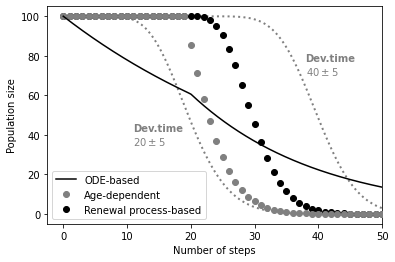

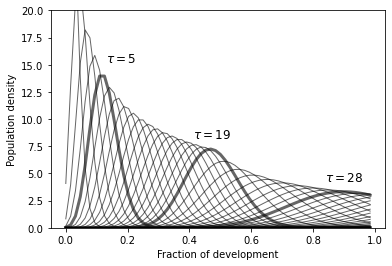

In [20]:
xr = numpy.arange(0,50,0.01)
xri = numpy.arange(0,200,1)
mu = numpy.array([40.0,20.0])
sd = numpy.array([5.0,5.0])
theta = sd * sd / mu
k = mu / theta

def ode(y, t):
    lam = 1.0 / 20.0 if t > 20.0 else 1.0 / 40.0
    dydt = [-lam * y[0]]
    return dydt
sol = odeint(ode, 100, xr)

a = spop(stochastic=False,gamma_fun="MODE_GAMMA_HASH")
a.add(0,0,0,0,100)
retH = [[0]+a.read()]
retL = [a.retrieve()]
for n in xri[1:]:
    i = 0 if n<20 else 1
    a.iterate(0,mu[i],sd[i],0,0,0)
    retH.append([n]+a.read())
retH = numpy.array(retH)

a = spop(stochastic=False,gamma_fun="MODE_ACCP_ERLANG")
a.add(0,0,0,0,100)
retA = [[0]+a.read()]
retL = [a.retrieve()]
for n in xri[1:]:
    i = 0 if n<20 else 1
    a.iterate(0,mu[i],sd[i],0,0,0)
    retA.append([n]+a.read())
    retL.append(a.retrieve())
retA = numpy.array(retA)
retL = numpy.array(retL)

for i in numpy.arange(len(mu))[::-1]:
    plt.plot(xr,100*(1.0-erlang.cdf(xr,k[i],0,theta[i])),c="gray",lw=2,ls="dotted")
plt.plot(xr,sol[:,0],c="black",label="ODE-based",zorder=30)
plt.plot(xri,retH[:,1],'o',ms=6,c="gray",label="Age-dependent",zorder=20)
plt.plot(xri,retA[:,1],'o',ms=6,c="black",label="Renewal process-based",zorder=10)
plt.text(11,35,"Dev.time\n$20\pm5$",c="gray",weight="bold")
plt.text(38,70,"Dev.time\n$40\pm5$",c="gray",weight="bold")
plt.ylim(-5,105)
plt.xlim(-2.5,50)
plt.legend()
plt.ylabel("Population size")
plt.xlabel("Number of steps")
plt.savefig("figures/Figure2a.pdf",bbox_inches="tight",dpi=300)
plt.show()

for i in range(len(retL)):
    r = retL[i]
    s = numpy.argsort(r[0])
    plt.plot(r[0][s],r[1][s],c="black",alpha=0.6,lw=3 if i in [5, 19, 28] else 1)
plt.text(0.13,15,r"$\tau=5$",horizontalalignment='left',verticalalignment='bottom',fontsize=12)
plt.text(0.475,8,r"$\tau=19$",horizontalalignment='center',verticalalignment='bottom',fontsize=12)
plt.text(0.9,4,r"$\tau=28$",horizontalalignment='center',verticalalignment='bottom',fontsize=12)
plt.ylim(0,20)
plt.ylabel("Population density")
plt.xlabel("Fraction of development")
plt.savefig("figures/Figure2b.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure 3a

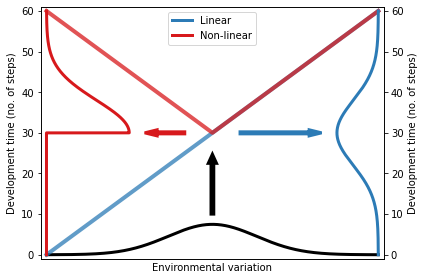

In [8]:
color = '#3182bd'

xr = numpy.arange(0,60,0.01)
yr = gaussian.pdf(xr,30,8)
zr = gaussian.pdf(xr,30,8)*2; zr[:int(zr.shape[0]/2)] = 0

fig, ax1 = plt.subplots()
ax1.set_xlim(-1,61)
ax1.set_ylim(-1,61)
ax1.set_xlabel("Environmental variation")
ax1.set_ylabel("Development time (no. of steps)", color="black")
plt.plot(xr,1.5e2*yr,color="black",lw=3)
plt.arrow(30,10,0,12.5,lw=3,width=0.5,linewidth=None,color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.xaxis.set_ticks([])
ax2 = ax1.twinx()
ax2.set_ylim(-1,61)
ax2.set_ylabel("Development time (no. of steps)", color="black")
plt.plot(xr,xr,lw=4,color="#2c7bb6",alpha=0.75)
plt.plot(xr,30+numpy.abs(xr-30),lw=4,color="#d7191c",alpha=0.75)
plt.plot(60-1.5e2*yr,xr,color="#2c7bb6",lw=3,label="Linear")
plt.arrow(25,30,-5,0,lw=3,width=0.5,linewidth=None,color="#d7191c")
plt.plot(1.5e2*zr,xr,color="#d7191c",lw=3,label="Non-linear")
plt.arrow(35,30,12.5,0,lw=3,width=0.5,linewidth=None,color="#2c7bb6")
ax2.tick_params(axis='y', labelcolor="black")
ax2.xaxis.set_ticks([])
plt.legend(loc="upper center")
fig.tight_layout()
plt.savefig("figures/Figure3a.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure 3b

Note: Due to the extended simulation time, the **run_noise.py** was used to generate the data plotted in this section.

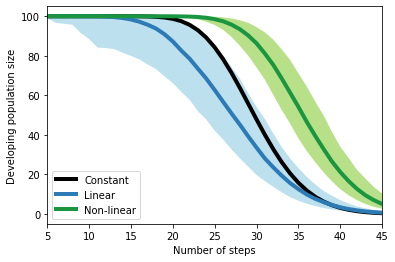

In [15]:
detA = pandas.DataFrame(run_noise.sim('fixed', eps=0.0, verbose=False), columns=('step','devtime','size','developed','dead'))
retAs = [
    run_noise.summarize(numpy.load("mat/run_noise_mlinear_n1000_e0.0001.npy")),
    run_noise.summarize(numpy.load("mat/run_noise_mnon-linear_n1000_e0.0001.npy"))
]

cols = ["#abd9e9","#a6d96a"]
colss = ["#2c7bb6","#1a9641"]
xr = numpy.arange(0,50,1)

labels = [r"Linear",r"Non-linear"]
plt.plot(detA['step'],detA['size'],c="black",lw=4,label=r"Constant")
for i in range(len(retAs)):
    ret = retAs[i]
    plt.fill_between(ret['median']['step'],ret['lower']['size'],ret['higher']['size'],facecolor=cols[i],edgecolor='none',alpha=0.8,lw=2)
    plt.plot(ret['median']['step'],ret['median']['size'],c=colss[i],lw=4,label=labels[i])
plt.legend(loc="lower left")
plt.ylabel("Developing population size")
plt.xlabel("Number of steps")
plt.xlim(5,45)
plt.savefig("figures/Figure3b.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure S1

Note: Due to the extended simulation time, the **run_noise.py** was used to generate the data plotted in this section.

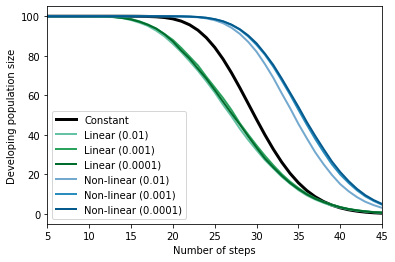

In [33]:
detA = pandas.DataFrame(run_noise.sim('fixed', eps=0.0, verbose=False), columns=('step','devtime','size','developed','dead'))
retAs = [
    run_noise.summarize(numpy.load("mat/run_noise_mlinear_n1000_e0.01.npy")),
    run_noise.summarize(numpy.load("mat/run_noise_mlinear_n1000_e0.001.npy")),
    run_noise.summarize(numpy.load("mat/run_noise_mlinear_n1000_e0.0001.npy")),
    run_noise.summarize(numpy.load("mat/run_noise_mnon-linear_n1000_e0.01.npy")),
    run_noise.summarize(numpy.load("mat/run_noise_mnon-linear_n1000_e0.001.npy")),
    run_noise.summarize(numpy.load("mat/run_noise_mnon-linear_n1000_e0.0001.npy"))
]

colss = ["#66c2a4","#2ca25f","#006d2c","#74a9cf","#2b8cbe","#045a8d"]
xr = numpy.arange(0,50,1)

labels = [r"Linear (0.01)",r"Linear (0.001)",r"Linear (0.0001)",r"Non-linear (0.01)",r"Non-linear (0.001)",r"Non-linear (0.0001)"]
lws = [2,2,2,2,2,2]
plt.plot(detA['step'],detA['size'],c="black",lw=3,label=r"Constant")
for i in range(len(retAs)):
    ret = retAs[i]
    plt.plot(ret['median']['step'],ret['median']['size'],c=colss[i],lw=lws[i],label=labels[i])
plt.legend(loc="lower left")
plt.ylabel("Developing population size")
plt.xlabel("Number of steps")
plt.xlim(5,45)
plt.savefig("figures/FigureS1.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure 4

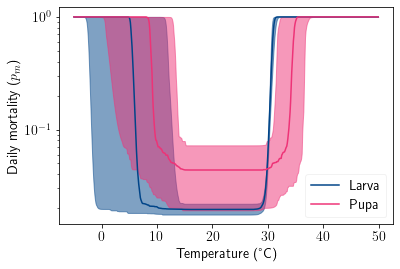

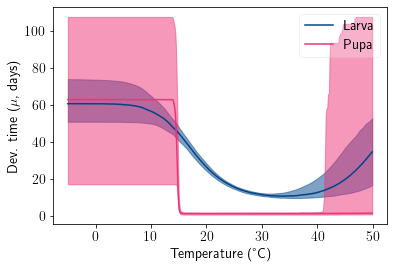

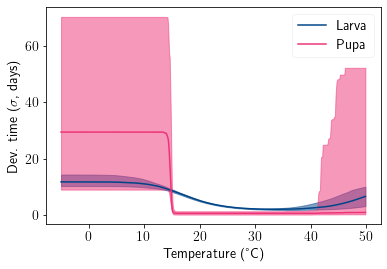

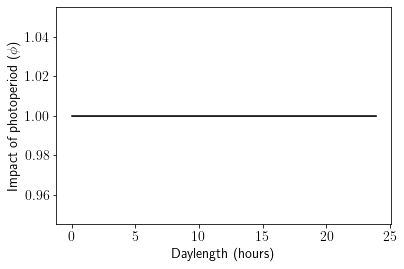

In [5]:
paramQ = modelsim.paramQ.copy()
model.plotPDC(paramQ, ylog=True, subset=True, filename="figures/param_Cxquin_C", filetype='pdf')

# Figure S2

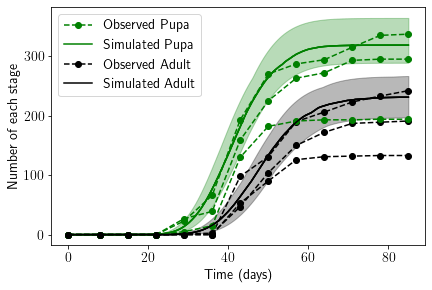

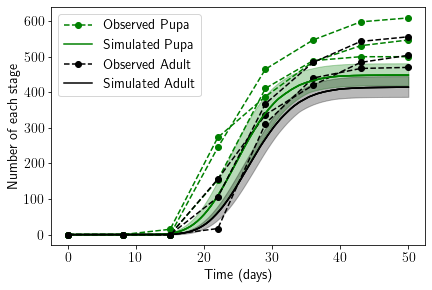

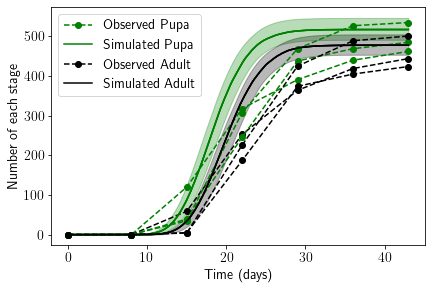

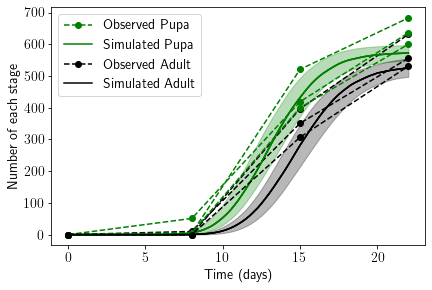

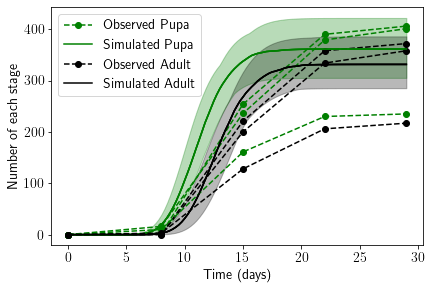

In [3]:
obs = [
            culex.obs['15-1'],
            culex.obs['15-2'],
            culex.obs['15-3'],
            culex.obs['20-1'],
            culex.obs['20-2'],
            culex.obs['20-3'],
            culex.obs['23-1'],
            culex.obs['23-2'],
            culex.obs['23-3'],
            culex.obs['27-1'],
            culex.obs['27-2'],
            culex.obs['27-3'],
            culex.obs['30-1'],
            culex.obs['30-2'],
            culex.obs['30-3']
        ]
groups = [[1,2],[4,5],[7,8],[10,11],[13,14]]
allgroups = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14]]
groupscore = [0,3,6,9,12]
paramQ = modelsim.paramQ.copy()

for grp in allgroups:
    model.plotMatches([obs[g] for g in grp],paramQ,dates=False,legend=True,filename="figures/ttest_Cxquin_"+"_".join([str(g) for g in grp]),filetype="pdf")

# Figure 5

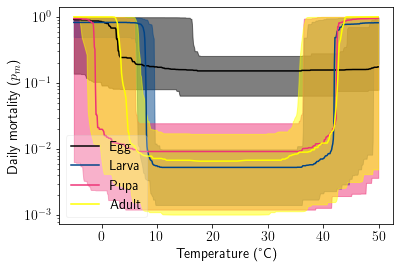

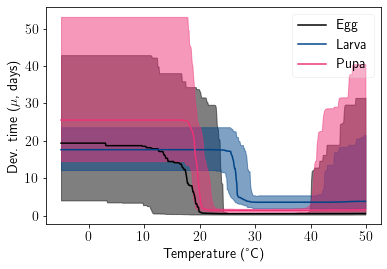

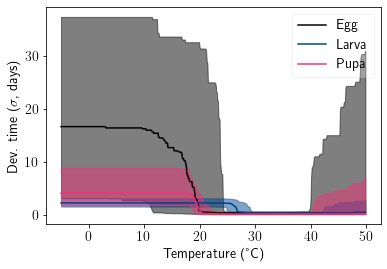

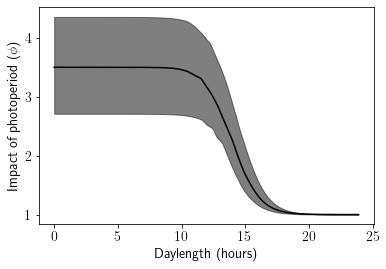

In [7]:
paramP = modelsim.paramP.copy()
model.plotPDC(paramP, ylog=True, filename="figures/param_Cxpip_C", filetype='pdf')

# Figure S3

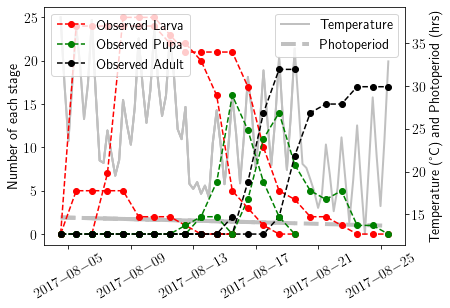

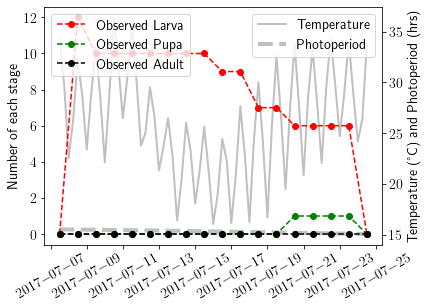

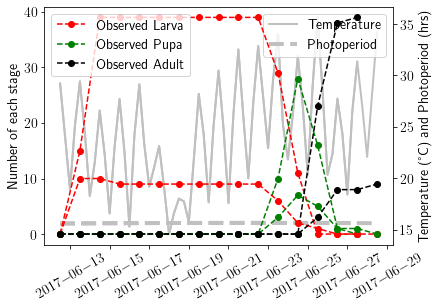

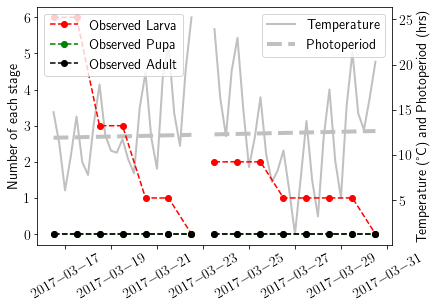

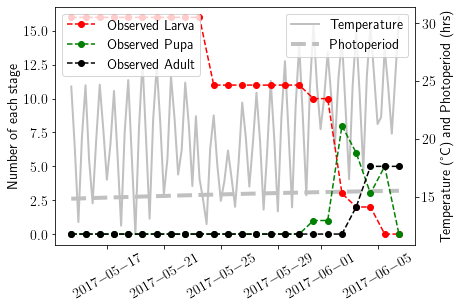

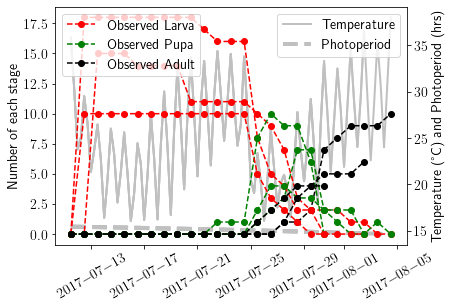

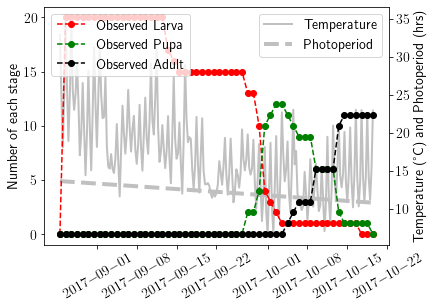

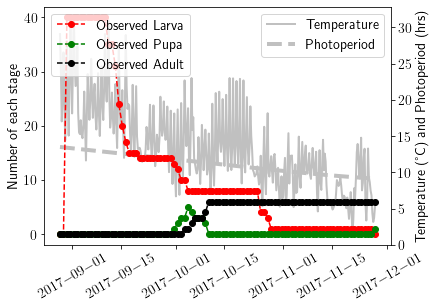

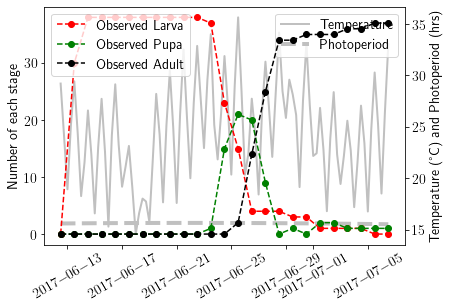

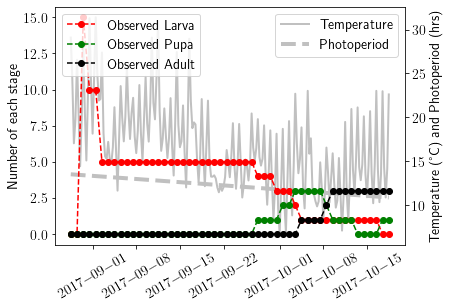

/Users/kamil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


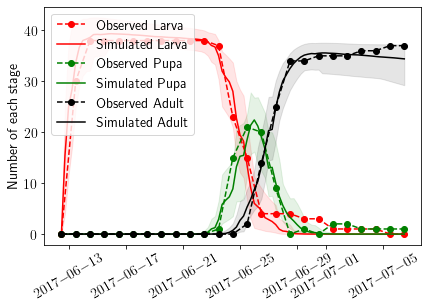

/Users/kamil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


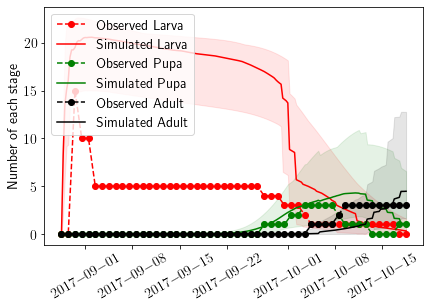

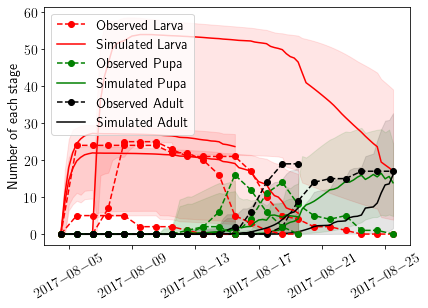

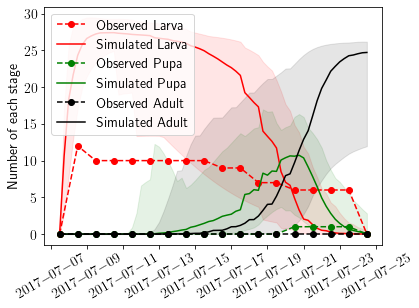

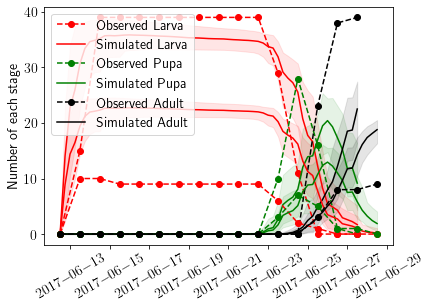

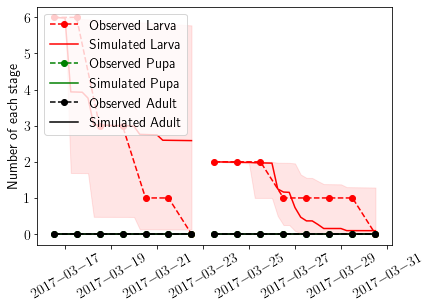

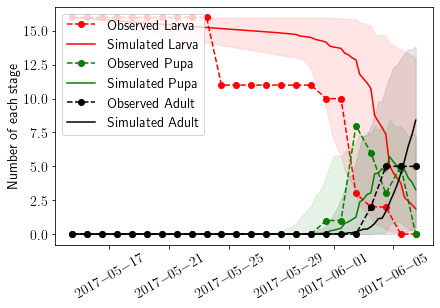

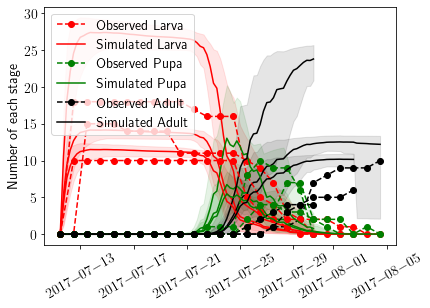

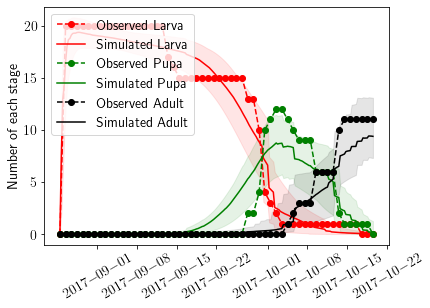

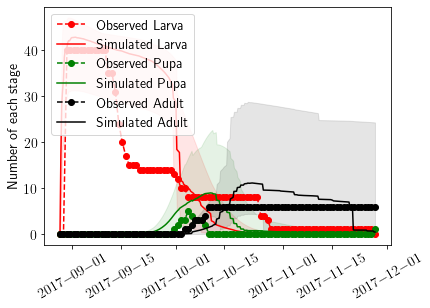

In [8]:
obs = [
            vtemp.obs[1],  #   0
            vtemp.obs[2],  #   1
            vtemp.obs[3],  #   2
            vtemp.obs[4],  #   3
            vtemp.obs[5],  #   4
            vtemp.obs[6],  #   5
            vtemp.obs[7],  #   6
            vtemp.obs[8],  #   7
            vtemp.obs[9],  #   8
            vtemp.obs[10], #   9
            vtemp.obs[11], #   10
            vtemp.obs[12], #   11
            vtemp.obs[13], #   12
            vtemp.obs[14], #   13
            vtemp.obs[15], #   14
            vtemp.obs[16]  #   15
        ]
groups = [[0,1,15],[2],[3,12],[4,5],[6],[7,13,14],[8],[10]]
allgroups = [[0,1,15],[2],[3,12],[4,5],[6],[7,13,14],[8],[10],[11],[9]]
groupscore = [11,9]
paramP = modelsim.paramP.copy()
for grp in allgroups:
    model.plotMatches([obs[g] for g in grp],[],dates=True,legend=True,envir=True,filename="figures/data_Cxpip_"+"_".join([str(g) for g in grp]),filetype="pdf")
for grp in groupscore:
    model.plotMatches([obs[grp]],paramP,dates=True,legend=True,envir=False,filename="figures/train_Cxpip_"+numpy.str(grp),filetype="pdf")
for grp in groups:
    model.plotMatches([obs[g] for g in grp],paramP,dates=True,legend=True,envir=False,filename="figures/test_Cxpip_"+"_".join([str(g) for g in grp]),filetype="pdf")